In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import calendar
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.interpolate import make_interp_spline

In [2]:
def read_data() -> pd.DataFrame:
    def restore_timezone(row: pd.Series) -> pd.Series:
        row.datetime = row.datetime.tz_convert(row.tz)
        return row
    
    def adjust_dst(row: pd.Series) -> pd.Series:
        if row.datetime.dst().total_seconds() > 0:
            row.datetime += pd.Timedelta(hours=1)
        return row

    d = pd.read_csv('preprocessing/commercial.csv')
    d.datetime = pd.to_datetime(d.datetime, utc=True)
    d = d.apply(restore_timezone, axis='columns')
    d = d.apply(adjust_dst, axis='columns')
    
    d['total'] = d.main + d.fans + d.cooling + d.heating + d.interior_lights + d.interior_equipment
    d['hour']  = d.datetime.apply(lambda dt: dt.hour)
    d['dow']   = d.datetime.apply(lambda dt: dt.day_of_week)
    d['doy']   = d.datetime.apply(lambda dt: dt.day_of_year)
    d['month'] = d.datetime.apply(lambda dt: dt.month)

    return d

In [3]:
d = read_data()

In [4]:
def quantile_plot(d: pd.DataFrame, **kwargs):
    grouper_col = kwargs.get('grouper_col', 'building_type')
    grouper_val_fmt = kwargs.get('grouper_val_fmt', lambda x: ' '.join(x.split('_')).title())
    plotter_col = kwargs.get('plotter_col', 'total')
    plotter_col_label = kwargs.get('plotter_col_label', 'Total energy consumption (kWh)')
    ncols = kwargs.get('ncols', 4)

    by_grouper = d.groupby(grouper_col)
    nrows = len(by_grouper) // ncols
    nrows += 1 if len(by_grouper) % ncols != 0 else 0
    cols = [plt.cm.tab20c(i) for i in range(4)]

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))

    for idx, (grp, ax) in enumerate(zip(by_grouper, axes.flat)):
        group_name, grp = grp
        hr = grp.datetime.apply(lambda dt: dt.hour)
        
        quantiles = (0.3, 0.4, 0.5, 0.6, 0.7)

        quantile_series = {
            q: grp.groupby(hr)[plotter_col].quantile(q).sort_index()
            for q in quantiles
        }
        x = {q: s.index for q, s in quantile_series.items()}
        y = {q: s.values for q, s in quantile_series.items()}

        if (k := kwargs.get('smooth')) is not None:
            xold, yold = x.copy(), y.copy()
            spl = {q: make_interp_spline(x=xold[q], y=yold[q], k=k) for q in xold}
            x = {q: np.linspace(s.min(), s.max(), num=100) for q, s in x.items()}
            y = {q: spl[q](x[q]) for q in y}

        ax.plot(x[quantiles[2]], y[quantiles[2]], color=cols[0])
        ax.fill_between(x[quantiles[1]], y[quantiles[1]], y[quantiles[3]], color=cols[1], alpha=0.5)
        ax.fill_between(x[quantiles[0]], y[quantiles[0]], y[quantiles[4]], color=cols[2], alpha=0.25)
        
        ax.set_title(grouper_val_fmt(group_name))
        ax.set_xticks(range(0, 24, 2))
        ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 24, 2)], rotation=90, ha='center')
        ax.spines['top'].set_color(None)
        ax.spines['right'].set_color(None)

        if idx % ncols == 0:
            ax.set_ylabel(plotter_col_label)

    for idx in range(len(by_grouper), nrows * ncols):
        fig.delaxes(axes.flat[idx])

    el = [
        Line2D([0], [0], color=cols[0], lw=2, label='Percentile 50'),
        Patch(facecolor=cols[1], edgecolor=cols[0], alpha=0.5, label='Percentiles 40-60'),
        Patch(facecolor=cols[2], edgecolor=cols[1], alpha=0.25, label='Percentiles 30-70'),
    ]

    figtop = 1.0
    bboxv = kwargs.get('bboxv', 1.05)

    if (title := kwargs.get('title')) is not None:
        fig.suptitle(title, fontsize=16)
        figtop = kwargs.get('figtop', 0.88)
        bboxv = kwargs.get('bboxv', 0.95)

    fig.legend(handles=el, loc='upper center', bbox_to_anchor=(0.5, bboxv), ncols=3)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.4, wspace=0.2, top=figtop)

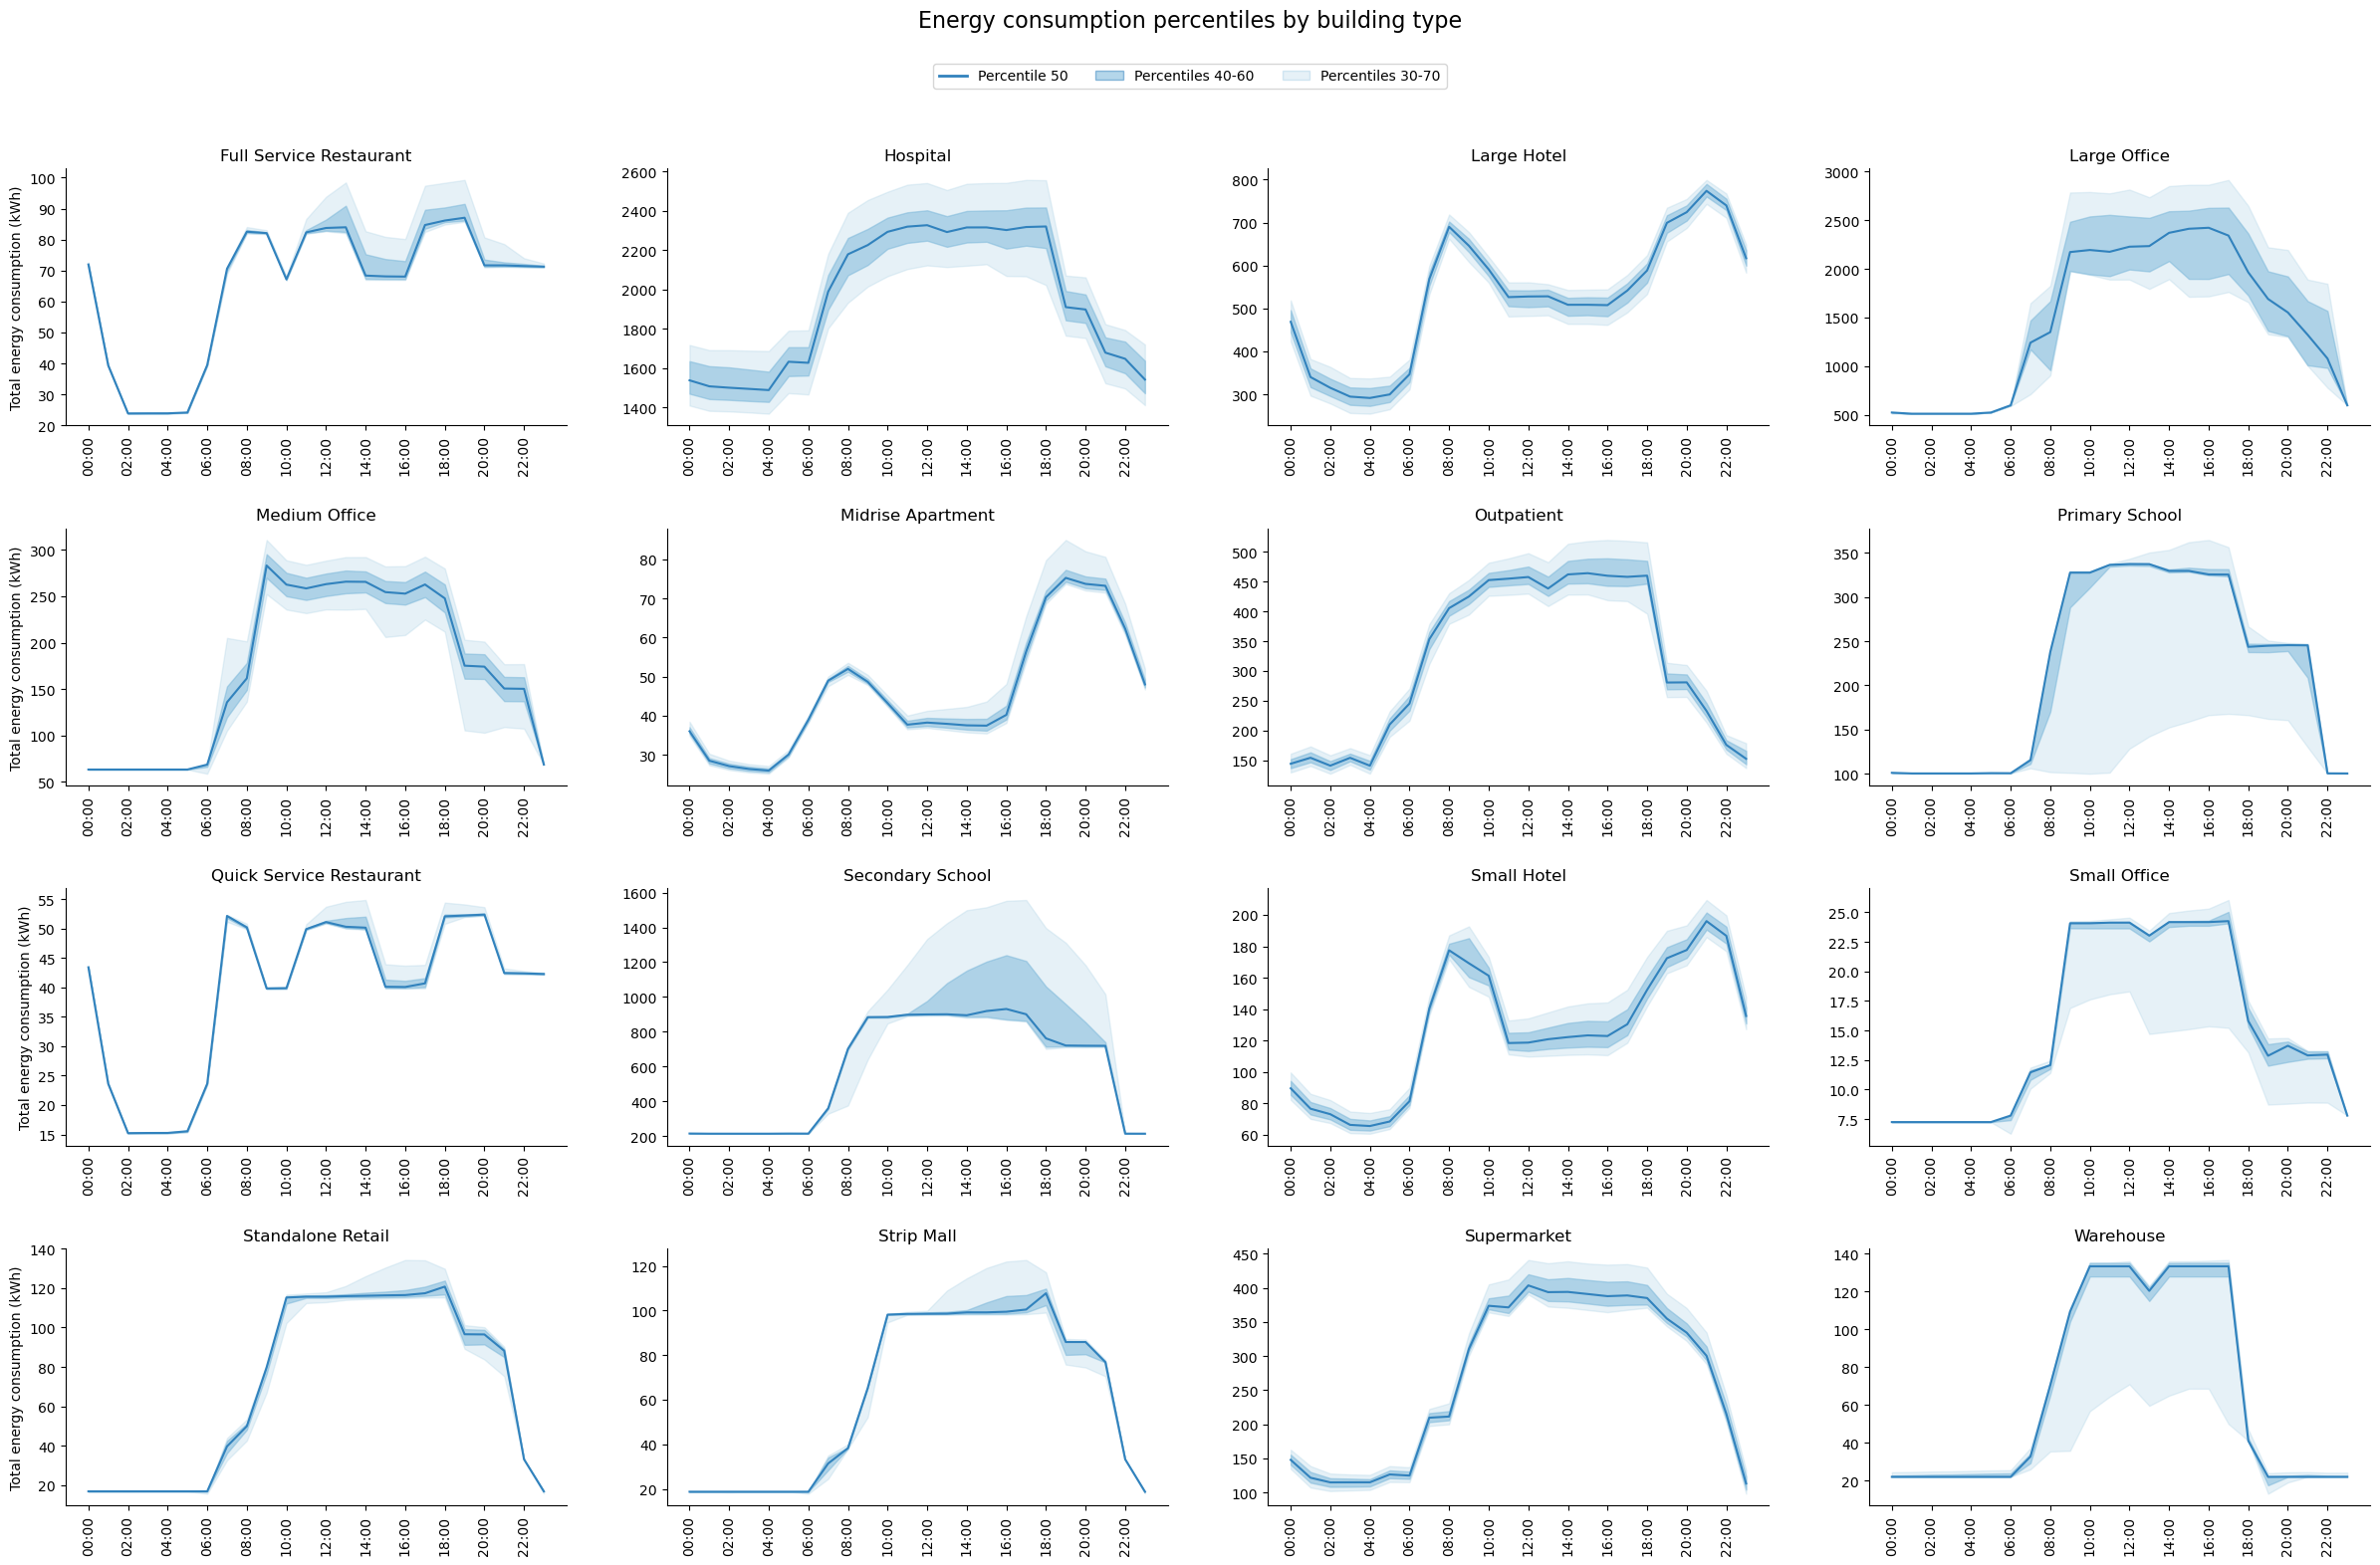

In [5]:
quantile_plot(d=d, title='Energy consumption percentiles by building type')

In [8]:
def ghost_plot(d: pd.DataFrame, **kwargs):
    grouper_col = kwargs.get('grouper_col', 'building_type')
    grouper_val_fmt = kwargs.get('grouper_val_fmt', lambda x: ' '.join(x.split('_')).title())
    plotter_col = kwargs.get('plotter_col', 'total')
    plotter_col_label = kwargs.get('plotter_col_label', 'Total energy consumption (kWh)')
    ncols = kwargs.get('ncols', 4)
    alpha = kwargs.get('alpha', 0.01)

    by_grouper = d.groupby(grouper_col)
    nrows = len(by_grouper) // ncols
    nrows += 1 if len(by_grouper) % ncols != 0 else 0

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))

    for idx, (grp, ax) in enumerate(zip(by_grouper, axes.flat)):
        group_name, grp = grp
        day = grp.datetime.apply(lambda dt: dt.day_of_year)

        for _, by_day in grp.groupby(day):
            hr = by_day.datetime.apply(lambda dt: dt.hour)
            pltd = by_day.groupby(hr)[plotter_col].mean()
            ax.plot(pltd.index, pltd.values, color='C0', alpha=alpha)

        ax.set_title(grouper_val_fmt(group_name))
        ax.set_xticks(range(0, 24, 2))
        ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 24, 2)], rotation=90, ha='center')
        ax.spines['top'].set_color(None)
        ax.spines['right'].set_color(None)

        if idx % ncols == 0:
            ax.set_ylabel(plotter_col_label)

    for idx in range(len(by_grouper), nrows * ncols):
        fig.delaxes(axes.flat[idx])

    figtop = 1.0

    if (title := kwargs.get('title')) is not None:
        fig.suptitle(title, fontsize=16)
        figtop = kwargs.get('figtop', 0.88)

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.4, wspace=0.2, top=figtop)

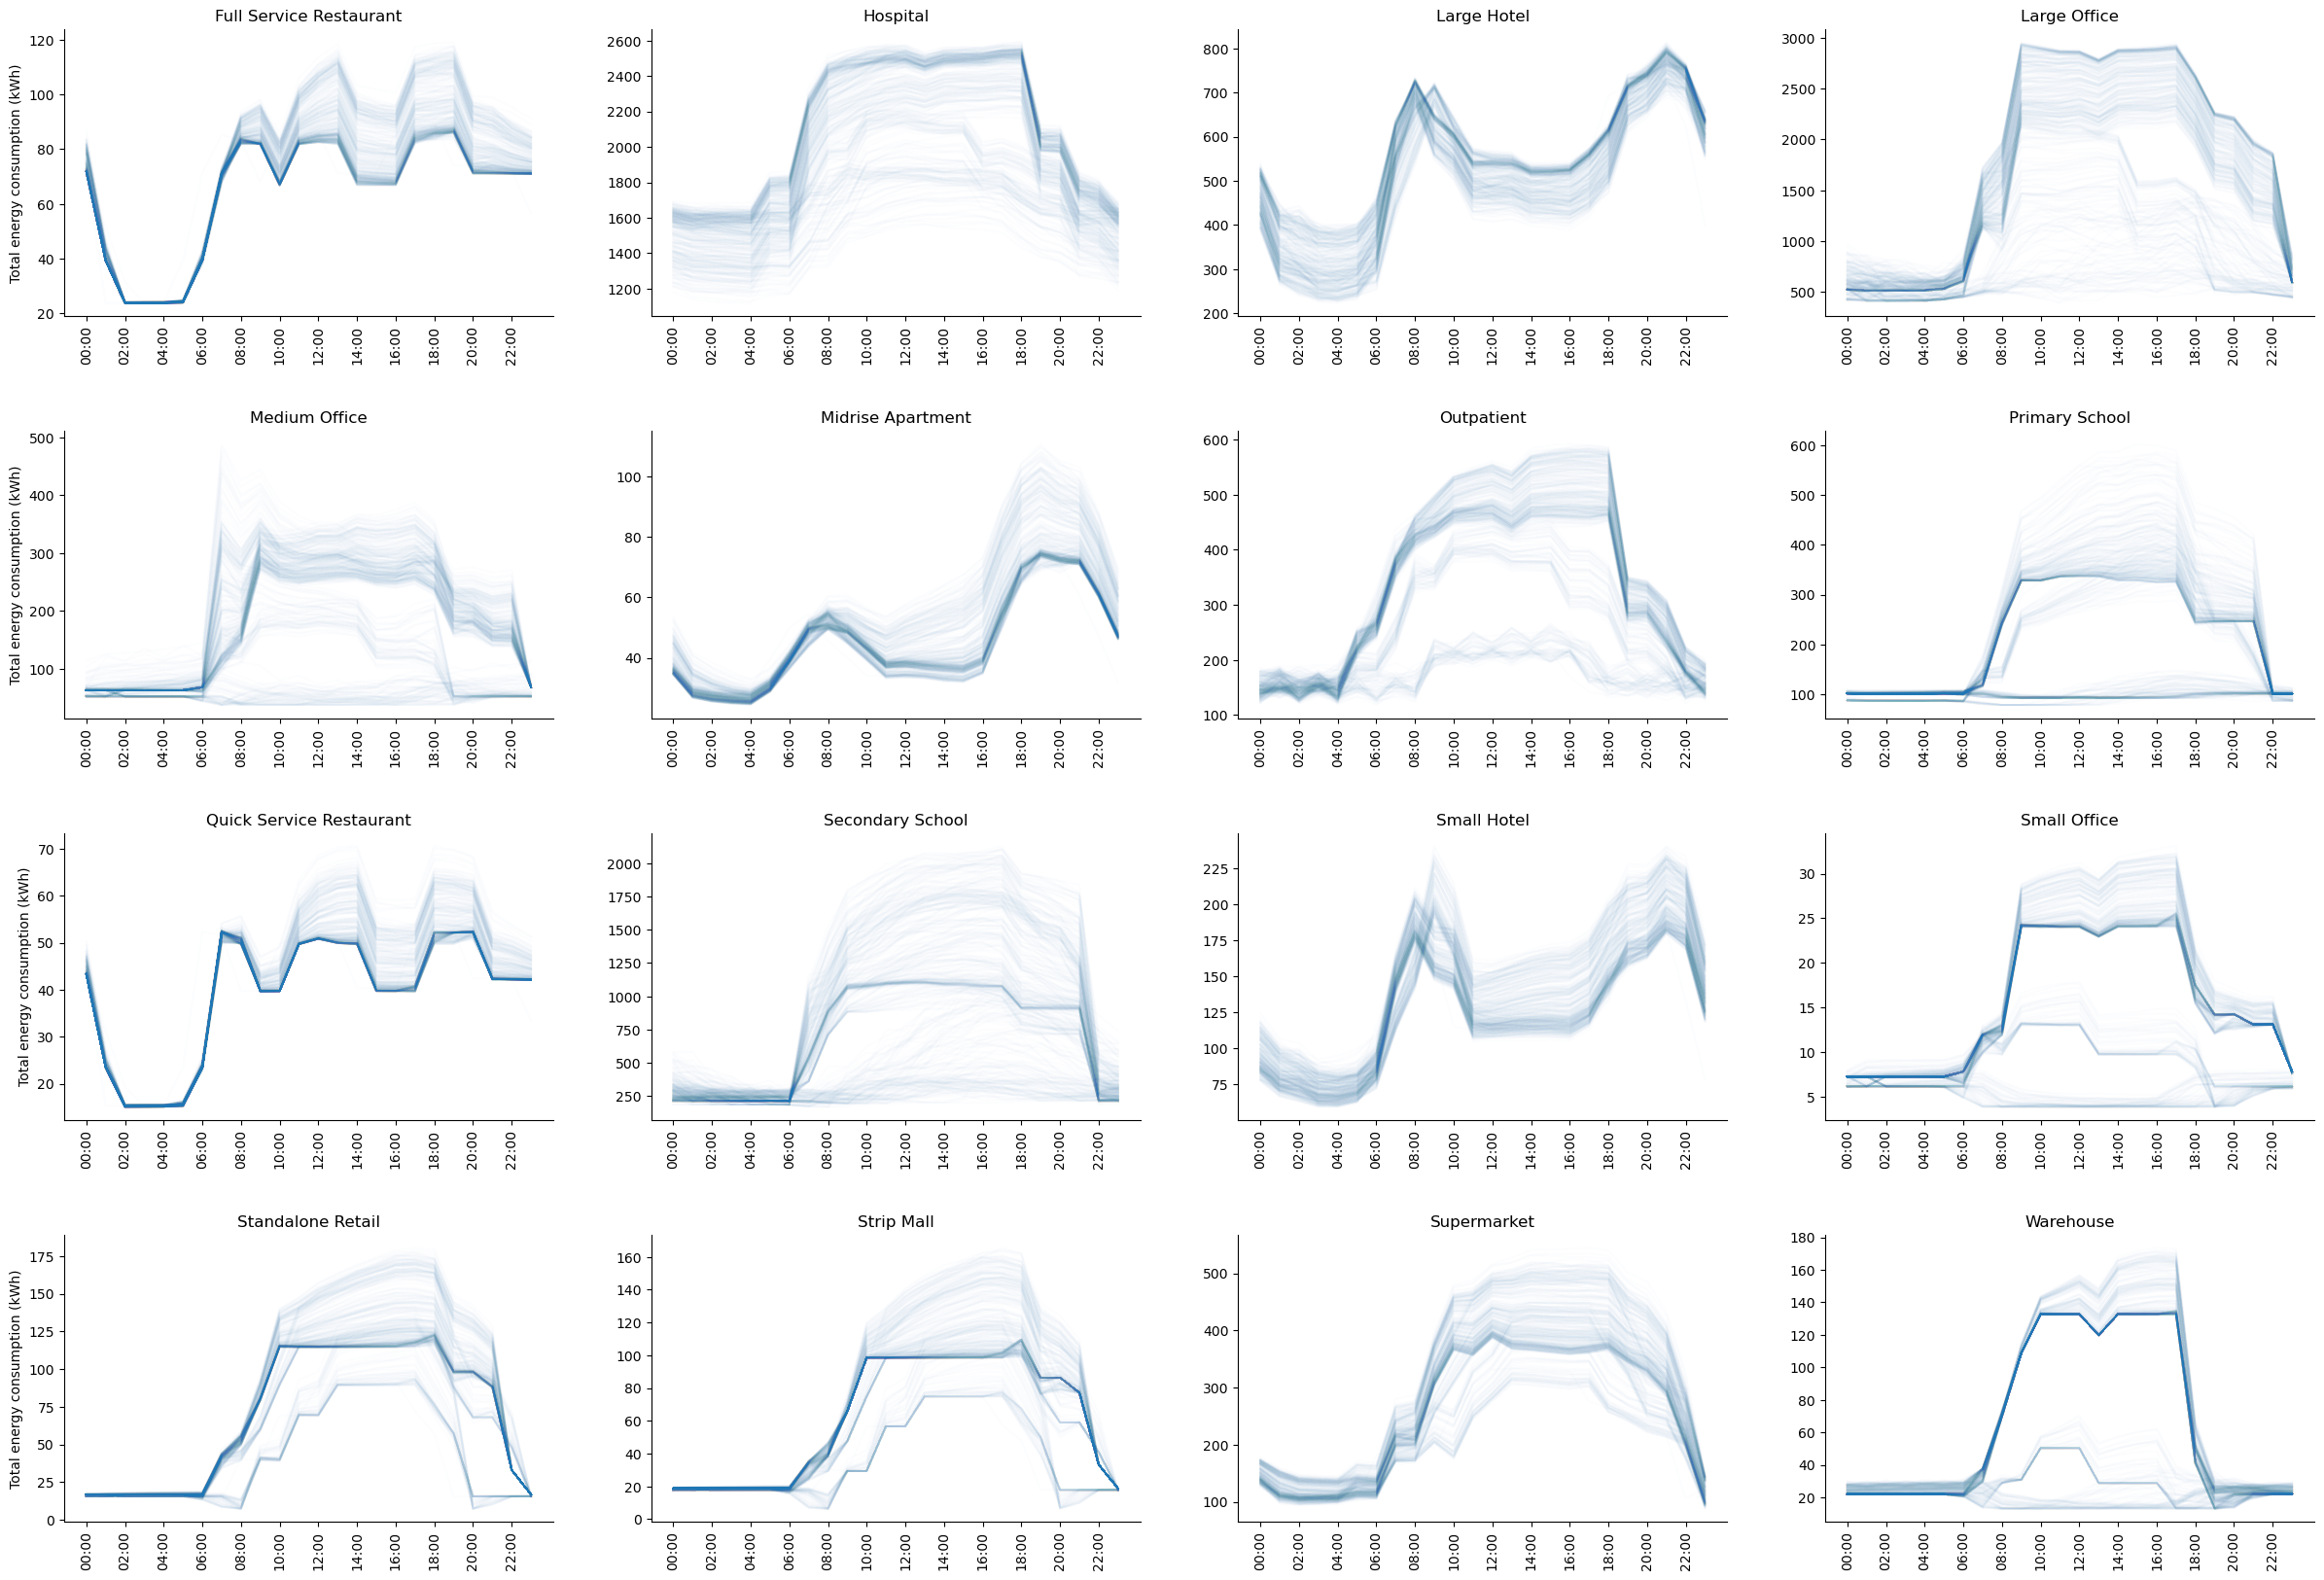

In [9]:
ghost_plot(d=d)

In [10]:
def heatmap(d: pd.DataFrame, **kwargs):
    grouper_col = kwargs.get('grouper_col', 'building_type')
    grouper_val_fmt = kwargs.get('grouper_val_fmt', lambda x: ' '.join(x.split('_')).title())
    plotter_col = kwargs.get('plotter_col', 'total')
    plotter_high_low_limit = kwargs.get('plotter_high_low_limit', 500)

    hr = d.datetime.apply(lambda dt: dt.hour)
    pd = d.pivot_table(index=grouper_col, columns=hr, values=plotter_col)

    pd_high = pd[pd.apply(lambda row: (row > plotter_high_low_limit).any(), axis='columns')]
    pd_low = pd[pd.apply(lambda row: (row <= plotter_high_low_limit).all(), axis='columns')]

    hmin, hmax = pd_high.min().min(), pd_high.max().max()
    lmin, lmax = pd_low.min().min(), pd_low.max().max()

    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 6), height_ratios=[len(pd_high), len(pd_low)], width_ratios=[95, 5])
    fig.subplots_adjust(wspace=0.3)

    sns.heatmap(data=pd_high, cmap='Blues', ax=axes.flat[0], cbar_ax=axes.flat[1], cbar_kws=dict(ticks=np.linspace(hmin, hmax, num=4)))
    sns.heatmap(data=pd_low, cmap='Greens', ax=axes.flat[2], cbar_ax=axes.flat[3], cbar_kws=dict(ticks=np.linspace(lmin, lmax, num=4)))

    for ax in (axes.flat[0], axes.flat[2]):
        for y in range(len(ax.get_yticklabels())):
            ax.axhline(y, color='white')

        ax.set_yticklabels([grouper_val_fmt(x.get_text()) for x in ax.get_yticklabels()])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(left=False, bottom=False)

    axes.flat[0].set_title('High-consumption group')
    axes.flat[2].set_title('Low-consumption group')

    fig.tight_layout()

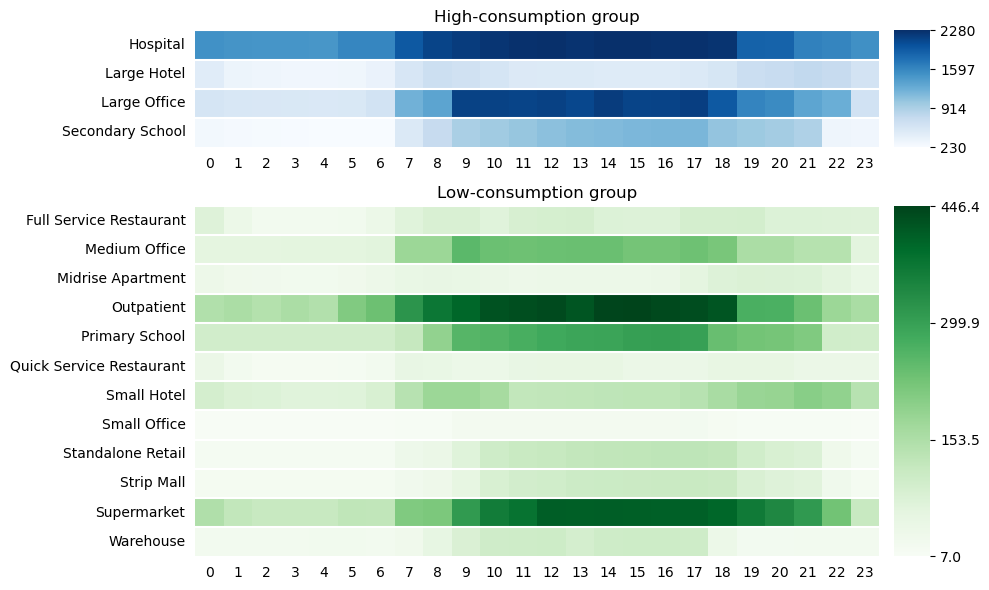

In [11]:
heatmap(d=d)

In [12]:
ps = d[d.building_type == 'primary_school']

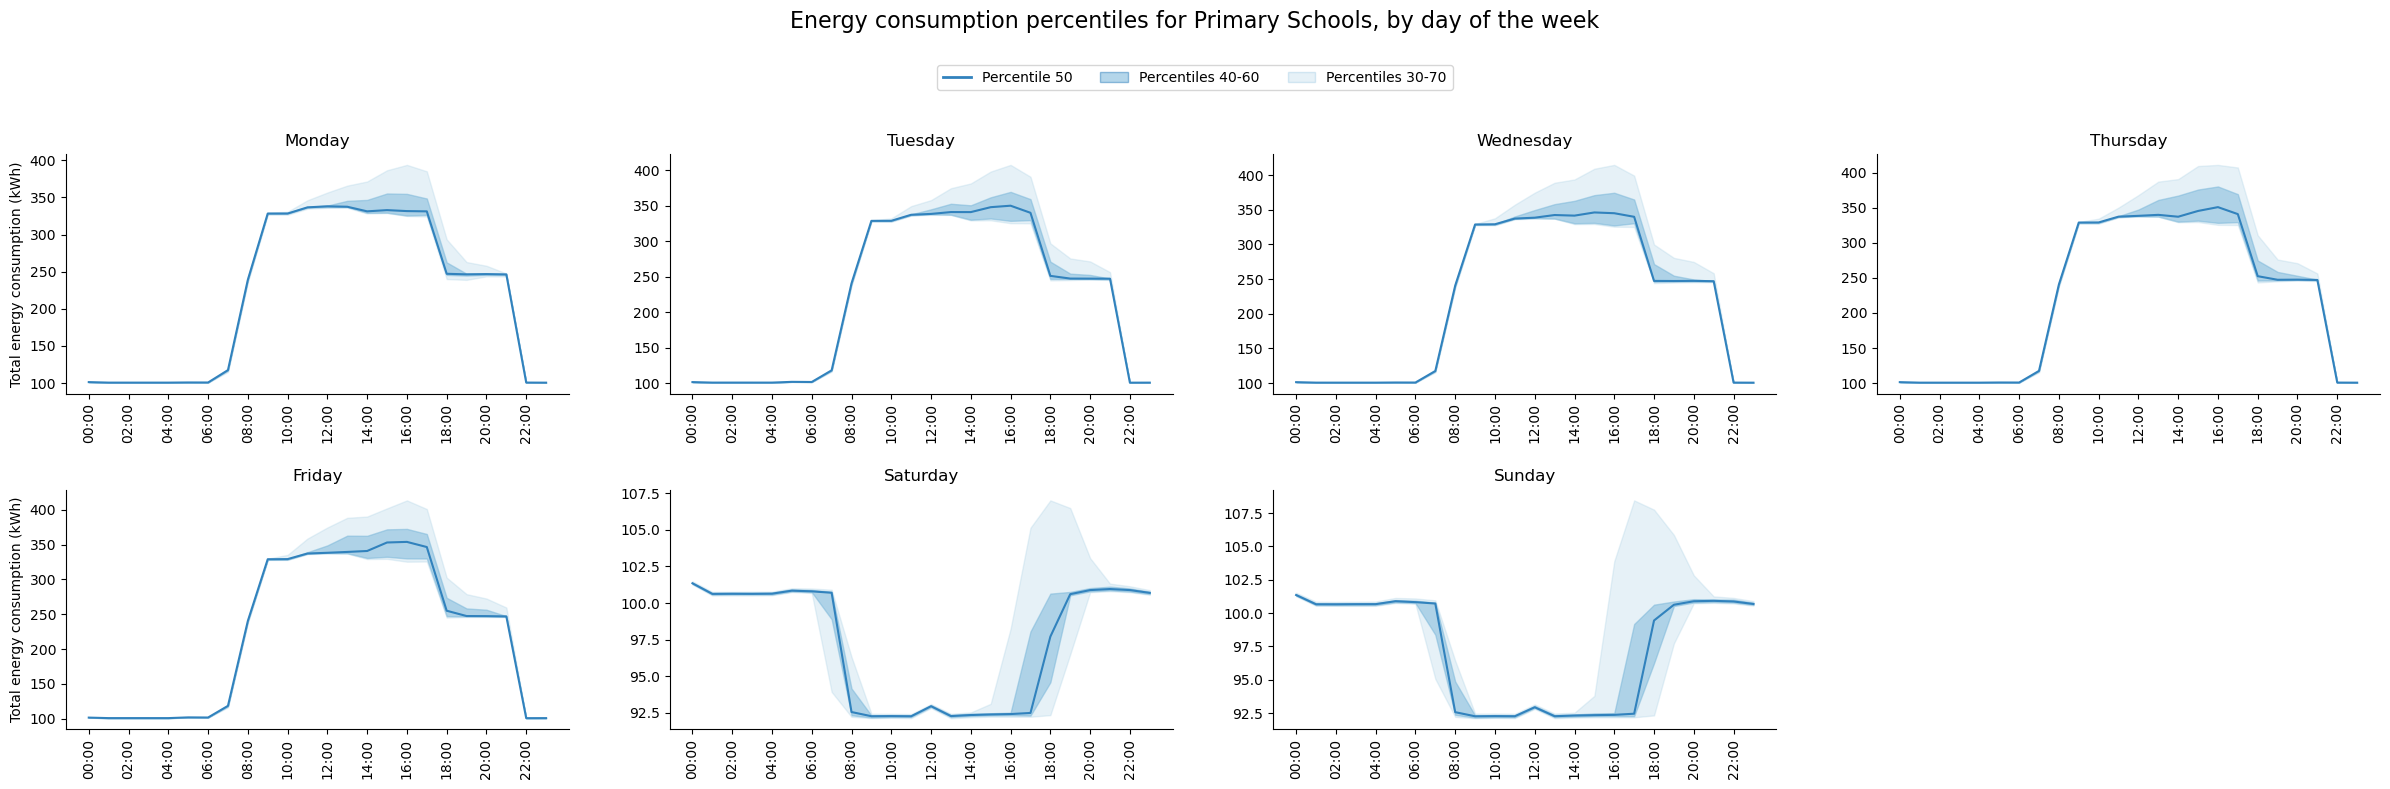

In [13]:
quantile_plot(d=ps, grouper_col='dow', grouper_val_fmt=lambda x: calendar.day_name[x], title='Energy consumption percentiles for Primary Schools, by day of the week', figtop=0.8, bboxv=0.92)

In [14]:
sm = d[d.building_type == 'strip_mall']

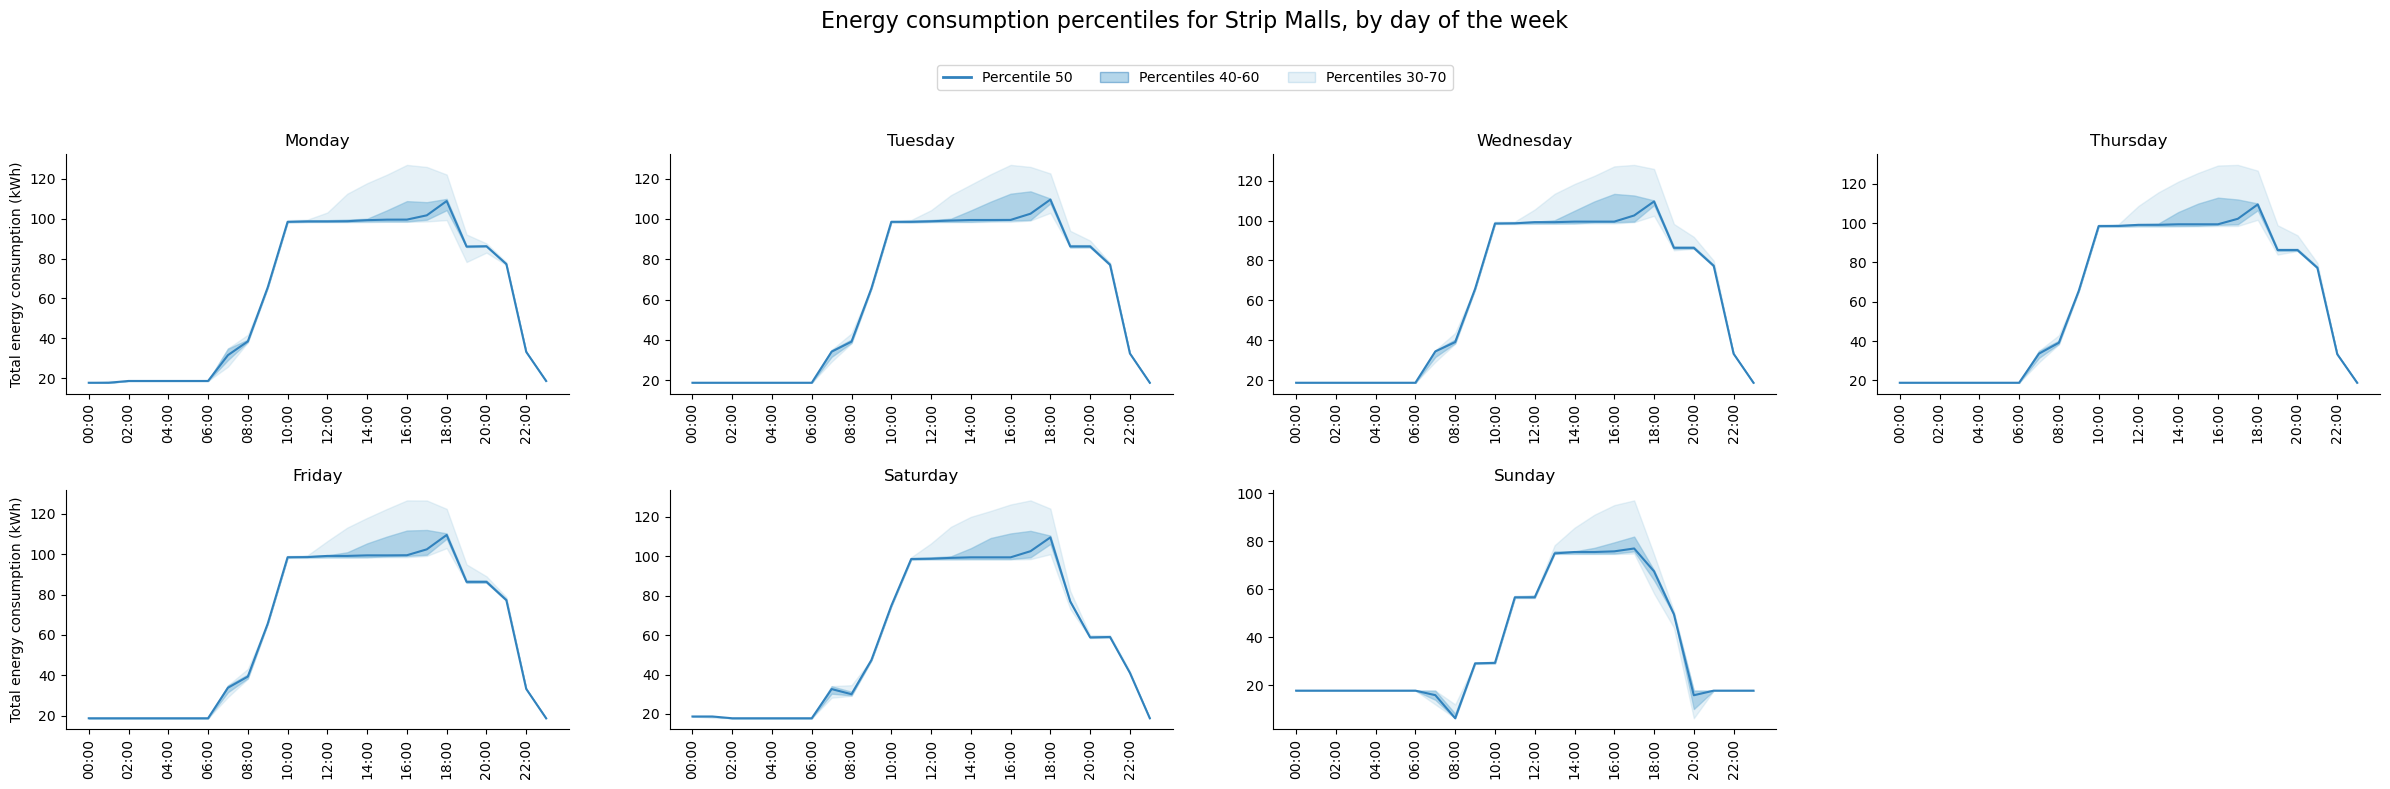

In [15]:
quantile_plot(d=sm, grouper_col='dow', grouper_val_fmt=lambda x: calendar.day_name[x], title='Energy consumption percentiles for Strip Malls, by day of the week', figtop=0.8, bboxv=0.92)

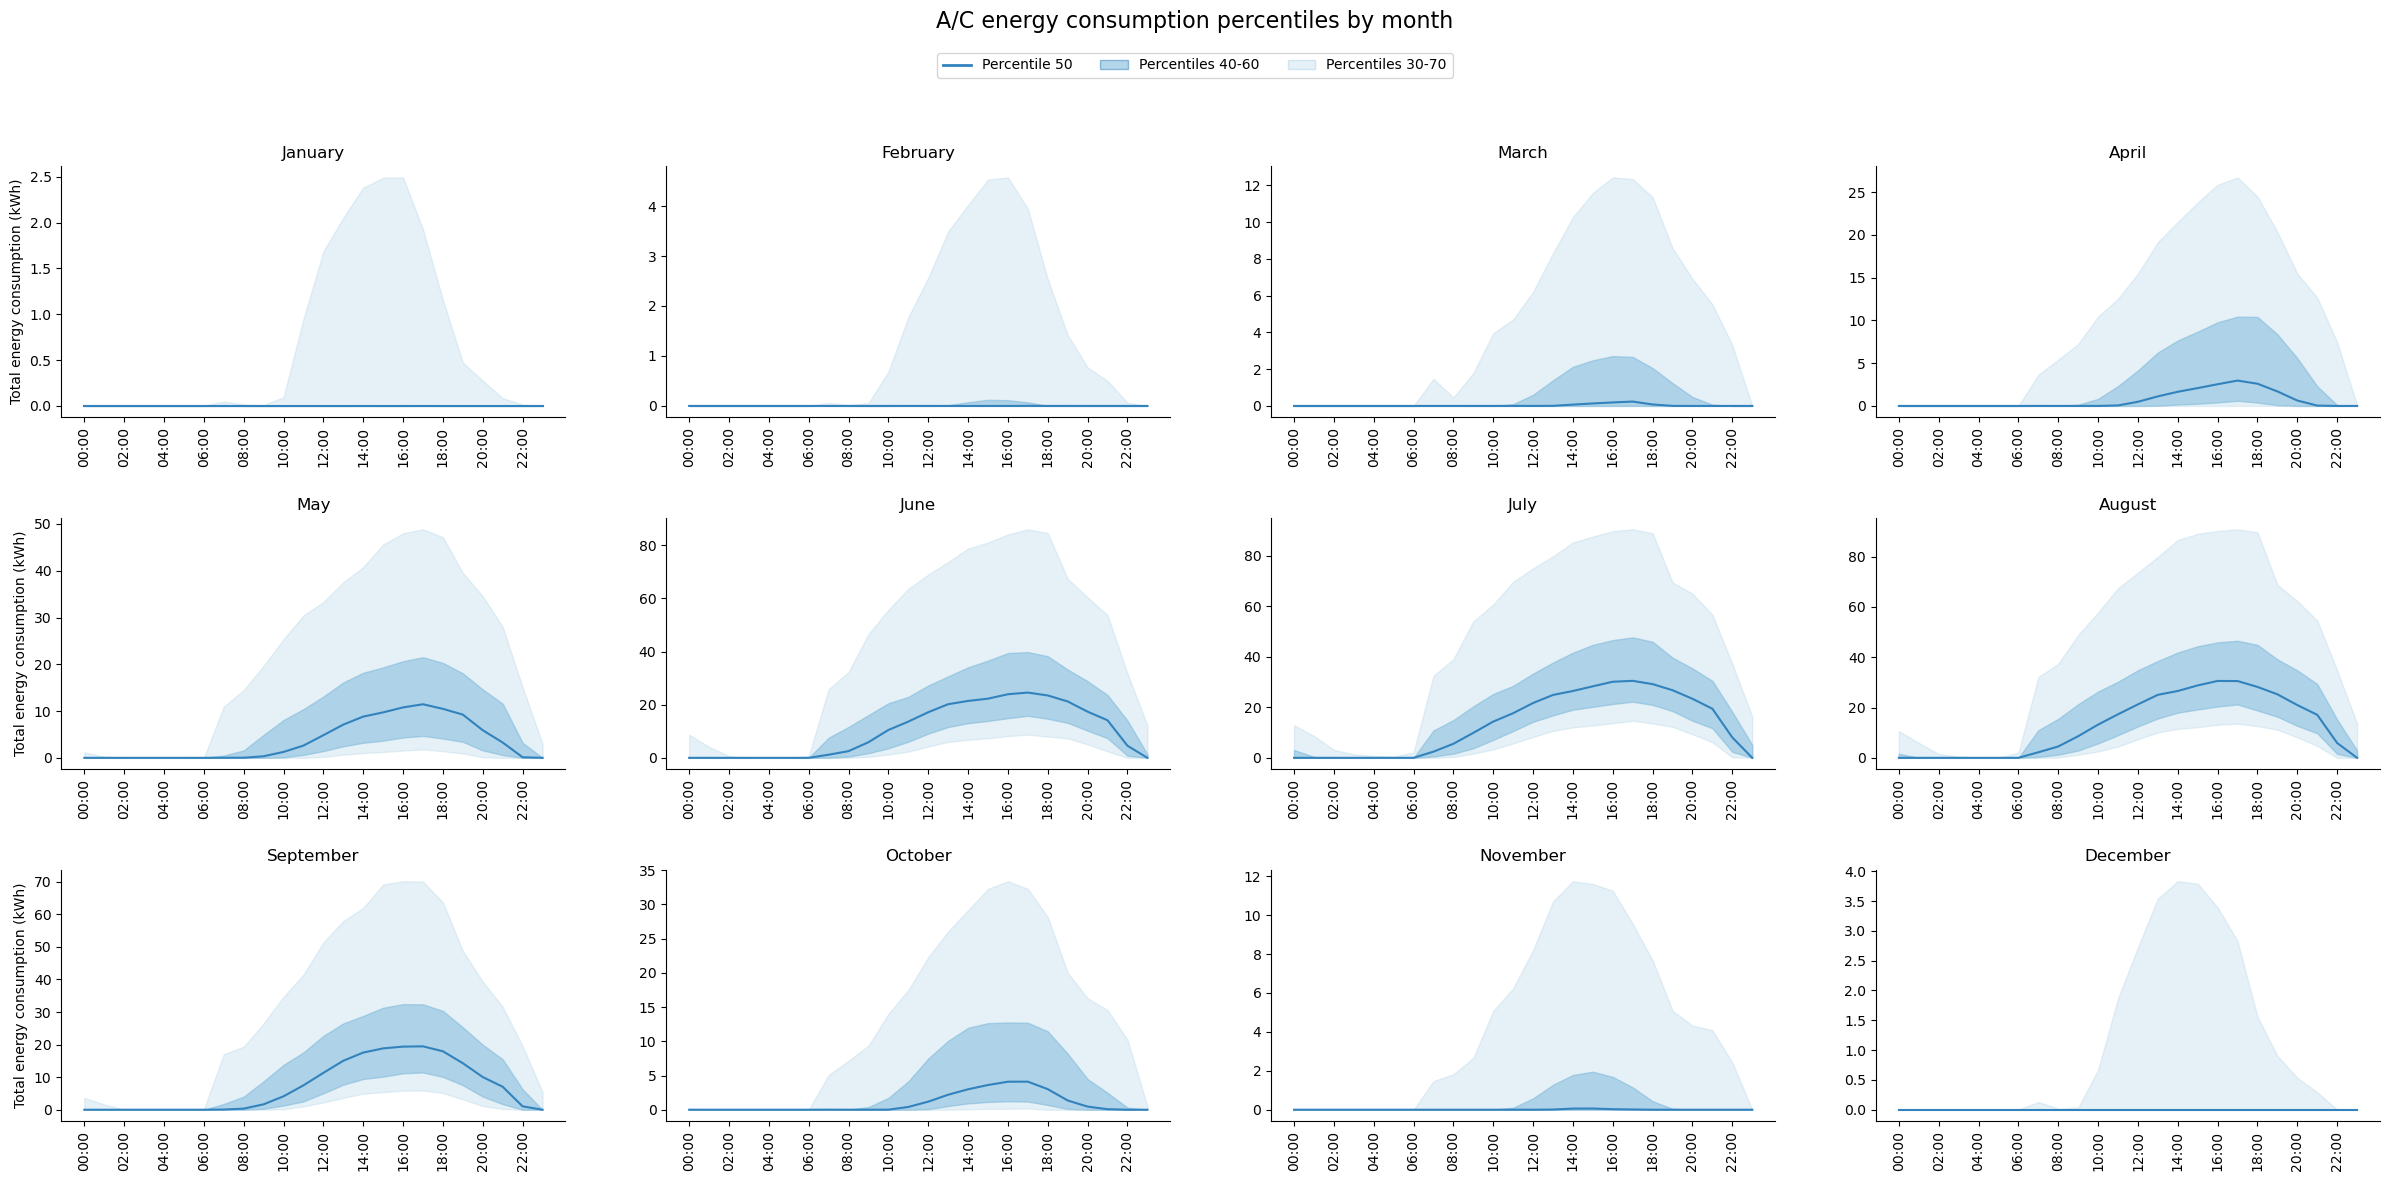

In [16]:
quantile_plot(d=d, plotter_col='cooling', grouper_col='month', grouper_val_fmt=lambda x: calendar.month_name[x], title='A/C energy consumption percentiles by month', figtop=0.85, bboxv=0.95)